Separate Buy/Sell Models - Training and Testing

[1/8] Loading datasets...
Training data shape: (2565, 79)
Testing data shape: (894, 79)

[2/8] Identifying common features...
Common features found: 65

[3/8] Splitting data by direction...

Training data:
  Buy signals:    1190 samples ( 46.4%)
  Sell signals:   1372 samples ( 53.6%)

Testing data:
  Buy signals:     502 samples ( 57.7%)
  Sell signals:    368 samples ( 42.3%)

[4/8] Preparing train/validation splits...

Buy Model:
  Train: 952, Val: 238, Test: 502

Sell Model:
  Train: 1097, Val: 275, Test: 368

[5/8] Training BUY model...
Best iteration: 116
Best validation score: 0.4836

[6/8] Training SELL model...
Best iteration: 163
Best validation score: 0.7788

[7/8] Evaluating models...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
BUY MODEL PERFORMANCE
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

Validation Set:
  RMSE:  0.4836%
  MAE:   0.3563%
  R²:    0.8323
  Direction Accuracy: 94.96%

Testing Set:
  RMSE:  1.0818%
  MAE:   0.85

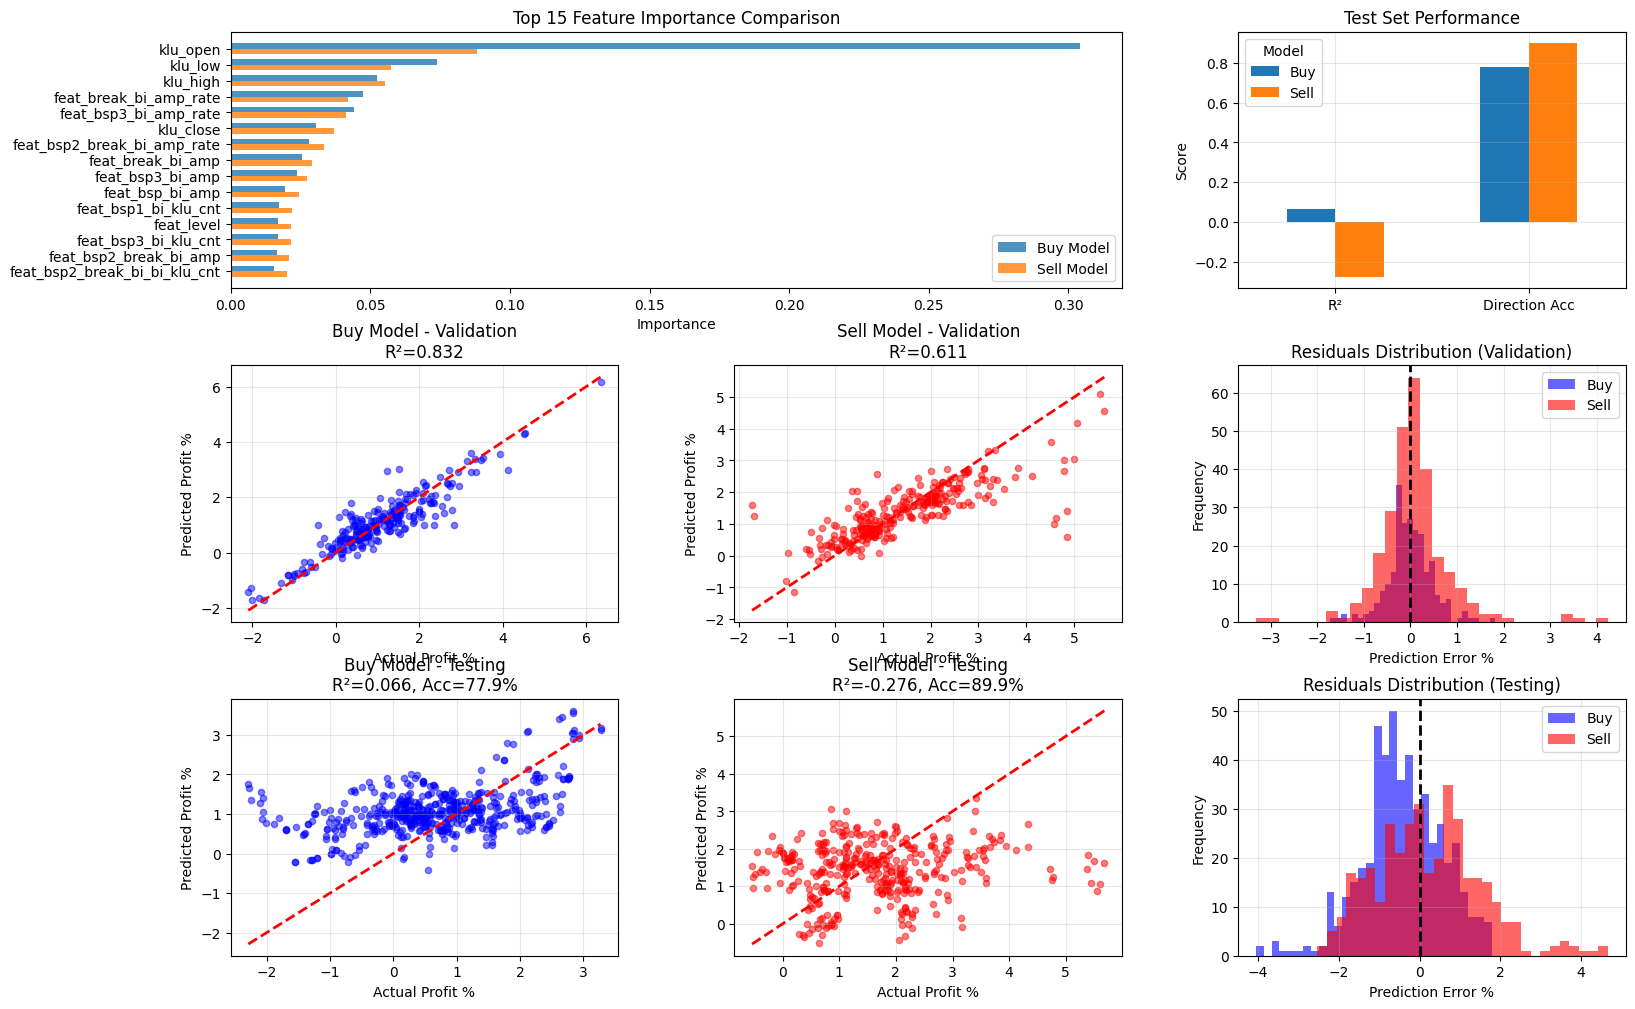

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration
# TRAINING_DATA_PATH = "./output/enhanced_bs_features/^GSPC_ml_training_dataset_23.1.1-4.1.csv"
# TESTING_DATA_PATH = "./output/testing_bs_features/^GSPC_testing_dataset_23.4.2-4.30.csv"
TRAINING_DATA_PATH = "./output/enhanced_bs_features/SPY_ml_training_dataset_22.1.1-4.1.csv"
TESTING_DATA_PATH = "./output/testing_bs_features/SPY_testing_dataset_22.4.2-4.30.csv"
OUTPUT_DIR = "./output/model_results"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("Separate Buy/Sell Models - Training and Testing")
print("=" * 80)

# Load datasets
print("\n[1/8] Loading datasets...")
train_df = pd.read_csv(TRAINING_DATA_PATH)
test_df = pd.read_csv(TESTING_DATA_PATH)

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Identify common features
print("\n[2/8] Identifying common features...")

# Exclude metadata and target columns
exclude_patterns = ['timestamp', 'bsp_type', 'direction', 'profit_target', 
                   'has_profit', 'return_', 'label_', 'target_return_', 
                   'snapshot_', 'klu_idx', 'exit_']

train_cols = set(train_df.columns)
test_cols = set(test_df.columns)
common_cols = train_cols.intersection(test_cols)

# Filter to feature columns only
feature_cols = [col for col in common_cols 
                if not any(col.startswith(pattern) for pattern in exclude_patterns)]

# Remove encoded columns if original exists
if 'direction' in feature_cols and 'direction_encoded' in feature_cols:
    feature_cols.remove('direction')
if 'bsp_type' in feature_cols and 'bsp_type_encoded' in feature_cols:
    feature_cols.remove('bsp_type')

feature_cols = sorted(feature_cols)

print(f"Common features found: {len(feature_cols)}")

# Split data by direction
print("\n[3/8] Splitting data by direction...")

# Training data
train_valid = train_df[train_df['has_profit_target'] == 1].copy()
train_buy = train_valid[train_valid['direction'] == 'buy'].copy()
train_sell = train_valid[train_valid['direction'] == 'sell'].copy()

print(f"\nTraining data:")
print(f"  Buy signals:  {len(train_buy):>6} samples ({len(train_buy)/len(train_valid)*100:>5.1f}%)")
print(f"  Sell signals: {len(train_sell):>6} samples ({len(train_sell)/len(train_valid)*100:>5.1f}%)")

# Testing data
test_valid = test_df[test_df['has_profit_target'] == 1].copy()
test_buy = test_valid[test_valid['direction'] == 'buy'].copy()
test_sell = test_valid[test_valid['direction'] == 'sell'].copy()

print(f"\nTesting data:")
print(f"  Buy signals:  {len(test_buy):>6} samples ({len(test_buy)/len(test_valid)*100:>5.1f}%)")
print(f"  Sell signals: {len(test_sell):>6} samples ({len(test_sell)/len(test_valid)*100:>5.1f}%)")

# Prepare data splits for both models
print("\n[4/8] Preparing train/validation splits...")

def prepare_data_split(data, feature_cols):
    """Split data into train/val sets"""
    X_full = data[feature_cols]
    y_full = data['profit_target_pct']
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_full, y_full, 
        test_size=0.2, 
        #random_state=42
    )
    
    # Handle missing values
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)
    
    return X_train, X_val, y_train, y_val

# Buy model data
X_train_buy, X_val_buy, y_train_buy, y_val_buy = prepare_data_split(train_buy, feature_cols)
X_test_buy = test_buy[feature_cols].fillna(0)
y_test_buy = test_buy['profit_target_pct']

# Sell model data
X_train_sell, X_val_sell, y_train_sell, y_val_sell = prepare_data_split(train_sell, feature_cols)
X_test_sell = test_sell[feature_cols].fillna(0)
y_test_sell = test_sell['profit_target_pct']

print(f"\nBuy Model:")
print(f"  Train: {len(X_train_buy)}, Val: {len(X_val_buy)}, Test: {len(X_test_buy)}")
print(f"\nSell Model:")
print(f"  Train: {len(X_train_sell)}, Val: {len(X_val_sell)}, Test: {len(X_test_sell)}")

# Model parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 20
}

# Train Buy Model
print("\n[5/8] Training BUY model...")
print("=" * 60)

model_buy = xgb.XGBRegressor(**params)
model_buy.fit(
    X_train_buy, y_train_buy,
    eval_set=[(X_val_buy, y_val_buy)],
    verbose=False
)

try:
    print(f"Best iteration: {model_buy.best_iteration}")
    print(f"Best validation score: {model_buy.best_score:.4f}")
except AttributeError:
    print("Model trained successfully")

# Train Sell Model
print("\n[6/8] Training SELL model...")
print("=" * 60)

model_sell = xgb.XGBRegressor(**params)
model_sell.fit(
    X_train_sell, y_train_sell,
    eval_set=[(X_val_sell, y_val_sell)],
    verbose=False
)

try:
    print(f"Best iteration: {model_sell.best_iteration}")
    print(f"Best validation score: {model_sell.best_score:.4f}")
except AttributeError:
    print("Model trained successfully")

# Evaluate both models
print("\n[7/8] Evaluating models...")
print("=" * 80)

def calculate_metrics(y_true, y_pred, dataset_name):
    """Calculate and display performance metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Trading metrics
    correct_direction = np.sum((y_true > 0) == (y_pred > 0))
    accuracy = correct_direction / len(y_true) * 100
    
    print(f"\n{dataset_name}:")
    print(f"  RMSE: {rmse:>7.4f}%")
    print(f"  MAE:  {mae:>7.4f}%")
    print(f"  R²:   {r2:>7.4f}")
    print(f"  Direction Accuracy: {accuracy:>5.2f}%")
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy': accuracy,
        'predictions': y_pred
    }

# Buy model predictions
y_val_buy_pred = model_buy.predict(X_val_buy)
y_test_buy_pred = model_buy.predict(X_test_buy)

print("\n" + "▶" * 40)
print("BUY MODEL PERFORMANCE")
print("▶" * 40)
buy_val_metrics = calculate_metrics(y_val_buy, y_val_buy_pred, "Validation Set")
buy_test_metrics = calculate_metrics(y_test_buy, y_test_buy_pred, "Testing Set")

# Sell model predictions
y_val_sell_pred = model_sell.predict(X_val_sell)
y_test_sell_pred = model_sell.predict(X_test_sell)

print("\n" + "▼" * 40)
print("SELL MODEL PERFORMANCE")
print("▼" * 40)
sell_val_metrics = calculate_metrics(y_val_sell, y_val_sell_pred, "Validation Set")
sell_test_metrics = calculate_metrics(y_test_sell, y_test_sell_pred, "Testing Set")

# Feature importance comparison
print("\n[8/8] Analyzing feature importance...")

feature_importance_buy = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_buy.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_sell = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_sell.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features - BUY Model:")
for i, row in feature_importance_buy.head(10).iterrows():
    print(f"  {row['feature']:40s}: {row['importance']:.4f}")

print("\nTop 10 Features - SELL Model:")
for i, row in feature_importance_sell.head(10).iterrows():
    print(f"  {row['feature']:40s}: {row['importance']:.4f}")

# Visualizations
print("\nGenerating visualizations...")

# 1. Model Comparison Dashboard
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: Feature Importance
ax1 = fig.add_subplot(gs[0, :2])
top_n = 15
top_buy = feature_importance_buy.head(top_n)
top_sell = feature_importance_sell.head(top_n)

x = np.arange(top_n)
width = 0.35

ax1.barh(x - width/2, top_buy['importance'].values, width, label='Buy Model', alpha=0.8)
ax1.barh(x + width/2, top_sell['importance'].values, width, label='Sell Model', alpha=0.8)
ax1.set_yticks(x)
ax1.set_yticklabels(top_buy['feature'].values)
ax1.set_xlabel('Importance')
ax1.set_title(f'Top {top_n} Feature Importance Comparison')
ax1.legend()
ax1.invert_yaxis()

# Performance comparison bar chart
ax2 = fig.add_subplot(gs[0, 2])
metrics_comparison = pd.DataFrame({
    'Buy': [buy_test_metrics['R2'], buy_test_metrics['Accuracy']/100],
    'Sell': [sell_test_metrics['R2'], sell_test_metrics['Accuracy']/100]
}, index=['R²', 'Direction Acc'])

metrics_comparison.plot(kind='bar', ax=ax2, rot=0)
ax2.set_title('Test Set Performance')
ax2.set_ylabel('Score')
ax2.legend(title='Model')
ax2.grid(True, alpha=0.3)

# Row 2: Predicted vs Actual - Validation
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_val_buy, y_val_buy_pred, alpha=0.5, s=20, color='blue')
ax3.plot([y_val_buy.min(), y_val_buy.max()], 
         [y_val_buy.min(), y_val_buy.max()], 'r--', lw=2)
ax3.set_xlabel('Actual Profit %')
ax3.set_ylabel('Predicted Profit %')
ax3.set_title(f'Buy Model - Validation\nR²={buy_val_metrics["R2"]:.3f}')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(y_val_sell, y_val_sell_pred, alpha=0.5, s=20, color='red')
ax4.plot([y_val_sell.min(), y_val_sell.max()], 
         [y_val_sell.min(), y_val_sell.max()], 'r--', lw=2)
ax4.set_xlabel('Actual Profit %')
ax4.set_ylabel('Predicted Profit %')
ax4.set_title(f'Sell Model - Validation\nR²={sell_val_metrics["R2"]:.3f}')
ax4.grid(True, alpha=0.3)

# Residuals comparison
ax5 = fig.add_subplot(gs[1, 2])
buy_residuals = y_val_buy - y_val_buy_pred
sell_residuals = y_val_sell - y_val_sell_pred
ax5.hist(buy_residuals, bins=30, alpha=0.6, label='Buy', color='blue')
ax5.hist(sell_residuals, bins=30, alpha=0.6, label='Sell', color='red')
ax5.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax5.set_xlabel('Prediction Error %')
ax5.set_ylabel('Frequency')
ax5.set_title('Residuals Distribution (Validation)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Row 3: Predicted vs Actual - Testing
ax6 = fig.add_subplot(gs[2, 0])
ax6.scatter(y_test_buy, y_test_buy_pred, alpha=0.5, s=20, color='blue')
ax6.plot([y_test_buy.min(), y_test_buy.max()], 
         [y_test_buy.min(), y_test_buy.max()], 'r--', lw=2)
ax6.set_xlabel('Actual Profit %')
ax6.set_ylabel('Predicted Profit %')
ax6.set_title(f'Buy Model - Testing\nR²={buy_test_metrics["R2"]:.3f}, Acc={buy_test_metrics["Accuracy"]:.1f}%')
ax6.grid(True, alpha=0.3)

ax7 = fig.add_subplot(gs[2, 1])
ax7.scatter(y_test_sell, y_test_sell_pred, alpha=0.5, s=20, color='red')
ax7.plot([y_test_sell.min(), y_test_sell.max()], 
         [y_test_sell.min(), y_test_sell.max()], 'r--', lw=2)
ax7.set_xlabel('Actual Profit %')
ax7.set_ylabel('Predicted Profit %')
ax7.set_title(f'Sell Model - Testing\nR²={sell_test_metrics["R2"]:.3f}, Acc={sell_test_metrics["Accuracy"]:.1f}%')
ax7.grid(True, alpha=0.3)

# Test residuals
ax8 = fig.add_subplot(gs[2, 2])
buy_test_residuals = y_test_buy - y_test_buy_pred
sell_test_residuals = y_test_sell - y_test_sell_pred
ax8.hist(buy_test_residuals, bins=30, alpha=0.6, label='Buy', color='blue')
ax8.hist(sell_test_residuals, bins=30, alpha=0.6, label='Sell', color='red')
ax8.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax8.set_xlabel('Prediction Error %')
ax8.set_ylabel('Frequency')
ax8.set_title('Residuals Distribution (Testing)')
ax8.legend()
ax8.grid(True, alpha=0.3)

plt.savefig(f"{OUTPUT_DIR}/separate_models_comparison.png", dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/separate_models_comparison.png")

# Save results
print("\nSaving detailed results...")

# Buy model results
test_buy_results = test_buy.copy()
test_buy_results['predicted_profit_pct'] = y_test_buy_pred
test_buy_results['prediction_error'] = y_test_buy - y_test_buy_pred
test_buy_results['correct_direction'] = (
    (test_buy_results['profit_target_pct'] > 0) == 
    (test_buy_results['predicted_profit_pct'] > 0)
).astype(int)
test_buy_results.to_csv(f"{OUTPUT_DIR}/buy_model_predictions.csv", index=False)

# Sell model results
test_sell_results = test_sell.copy()
test_sell_results['predicted_profit_pct'] = y_test_sell_pred
test_sell_results['prediction_error'] = y_test_sell - y_test_sell_pred
test_sell_results['correct_direction'] = (
    (test_sell_results['profit_target_pct'] > 0) == 
    (test_sell_results['predicted_profit_pct'] > 0)
).astype(int)
test_sell_results.to_csv(f"{OUTPUT_DIR}/sell_model_predictions.csv", index=False)

# Combined results for easy comparison
combined_results = pd.concat([test_buy_results, test_sell_results]).sort_values('klu_idx')
combined_results.to_csv(f"{OUTPUT_DIR}/combined_predictions.csv", index=False)

print(f"Saved: {OUTPUT_DIR}/buy_model_predictions.csv")
print(f"Saved: {OUTPUT_DIR}/sell_model_predictions.csv")
print(f"Saved: {OUTPUT_DIR}/combined_predictions.csv")

# Save models
model_buy.save_model(f"{OUTPUT_DIR}/xgboost_buy_model.json")
model_sell.save_model(f"{OUTPUT_DIR}/xgboost_sell_model.json")
print(f"Saved: {OUTPUT_DIR}/xgboost_buy_model.json")
print(f"Saved: {OUTPUT_DIR}/xgboost_sell_model.json")

# Save feature importance
feature_importance_buy.to_csv(f"{OUTPUT_DIR}/buy_model_feature_importance.csv", index=False)
feature_importance_sell.to_csv(f"{OUTPUT_DIR}/sell_model_feature_importance.csv", index=False)

# Summary report
with open(f"{OUTPUT_DIR}/separate_models_summary.txt", 'w') as f:
    f.write("Separate Buy/Sell Models - Summary Report\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("DATA SPLIT:\n")
    f.write(f"  Training:\n")
    f.write(f"    Buy signals:  {len(train_buy):>6} samples\n")
    f.write(f"    Sell signals: {len(train_sell):>6} samples\n")
    f.write(f"  Testing:\n")
    f.write(f"    Buy signals:  {len(test_buy):>6} samples\n")
    f.write(f"    Sell signals: {len(test_sell):>6} samples\n\n")
    
    f.write("BUY MODEL PERFORMANCE:\n")
    f.write(f"  Validation:\n")
    f.write(f"    RMSE: {buy_val_metrics['RMSE']:.4f}%\n")
    f.write(f"    MAE:  {buy_val_metrics['MAE']:.4f}%\n")
    f.write(f"    R²:   {buy_val_metrics['R2']:.4f}\n")
    f.write(f"    Acc:  {buy_val_metrics['Accuracy']:.2f}%\n")
    f.write(f"  Testing:\n")
    f.write(f"    RMSE: {buy_test_metrics['RMSE']:.4f}%\n")
    f.write(f"    MAE:  {buy_test_metrics['MAE']:.4f}%\n")
    f.write(f"    R²:   {buy_test_metrics['R2']:.4f}\n")
    f.write(f"    Acc:  {buy_test_metrics['Accuracy']:.2f}%\n\n")
    
    f.write("SELL MODEL PERFORMANCE:\n")
    f.write(f"  Validation:\n")
    f.write(f"    RMSE: {sell_val_metrics['RMSE']:.4f}%\n")
    f.write(f"    MAE:  {sell_val_metrics['MAE']:.4f}%\n")
    f.write(f"    R²:   {sell_val_metrics['R2']:.4f}\n")
    f.write(f"    Acc:  {sell_val_metrics['Accuracy']:.2f}%\n")
    f.write(f"  Testing:\n")
    f.write(f"    RMSE: {sell_test_metrics['RMSE']:.4f}%\n")
    f.write(f"    MAE:  {sell_test_metrics['MAE']:.4f}%\n")
    f.write(f"    R²:   {sell_test_metrics['R2']:.4f}\n")
    f.write(f"    Acc:  {sell_test_metrics['Accuracy']:.2f}%\n\n")
    
    f.write("TOP 10 BUY MODEL FEATURES:\n")
    for i, row in feature_importance_buy.head(10).iterrows():
        f.write(f"  {i+1:2d}. {row['feature']:40s}: {row['importance']:.4f}\n")
    
    f.write("\nTOP 10 SELL MODEL FEATURES:\n")
    for i, row in feature_importance_sell.head(10).iterrows():
        f.write(f"  {i+1:2d}. {row['feature']:40s}: {row['importance']:.4f}\n")

print(f"Saved: {OUTPUT_DIR}/separate_models_summary.txt")

# Final summary
print("\n" + "=" * 80)
print("SEPARATE MODEL TRAINING COMPLETE")
print("=" * 80)

print(f"\n📊 BUY MODEL RESULTS:")
print(f"  Testing R²:               {buy_test_metrics['R2']:>7.4f}")
print(f"  Testing MAE:              {buy_test_metrics['MAE']:>7.4f}%")
print(f"  Direction Accuracy:       {buy_test_metrics['Accuracy']:>7.2f}%")

print(f"\n📊 SELL MODEL RESULTS:")
print(f"  Testing R²:               {sell_test_metrics['R2']:>7.4f}")
print(f"  Testing MAE:              {sell_test_metrics['MAE']:>7.4f}%")
print(f"  Direction Accuracy:       {sell_test_metrics['Accuracy']:>7.2f}%")

print(f"\n📈 COMPARISON:")
r2_diff = buy_test_metrics['R2'] - sell_test_metrics['R2']
acc_diff = buy_test_metrics['Accuracy'] - sell_test_metrics['Accuracy']

if abs(r2_diff) > 0.05:
    better = "BUY" if r2_diff > 0 else "SELL"
    print(f"  {better} model performs significantly better (R² diff: {abs(r2_diff):.3f})")
else:
    print(f"  Both models perform similarly (R² diff: {abs(r2_diff):.3f})")

if abs(acc_diff) > 5:
    better = "BUY" if acc_diff > 0 else "SELL"
    print(f"  {better} model has better direction accuracy ({abs(acc_diff):.1f}% difference)")

print(f"\n💾 All results saved to: {OUTPUT_DIR}/")
print(f"\n✅ Use 'buy_model' for buy signals and 'sell_model' for sell signals")

plt.show()

Portfolio Backtesting: Separate Buy/Sell Models vs Buy & Hold

[1/5] Loading model predictions...
[2/5] Loading S&P 500 historical data...
S&P 500 data points in test period: 726
ML signals in test period: 726
  - Buy signals:  415
  - Sell signals: 311
Date range: 2022/06/02 06:25 to 2022/06/30 15:15

[3/5] Running backtest with separate models...

[4/5] Calculating performance metrics...

BACKTEST RESULTS

Initial Capital: $10,000.00
Trading Period: 2022/06/02 06:25 to 2022/06/30 15:15
Total Days: 726
Total ML Signals: 726
Buy & Hold using: Full S&P 500 daily prices

--------------------------------------------------------------------------------
ML TRADING STRATEGY (Separate Buy/Sell Models)
--------------------------------------------------------------------------------
Strategy: Use BUY model for entries, SELL model for exits
  - Buy Threshold:  2% (from buy_model)
  - Sell Threshold: 2% (from sell_model)
Position Size: 100% per trade
Final Portfolio Value: $10,149.21
Total Return

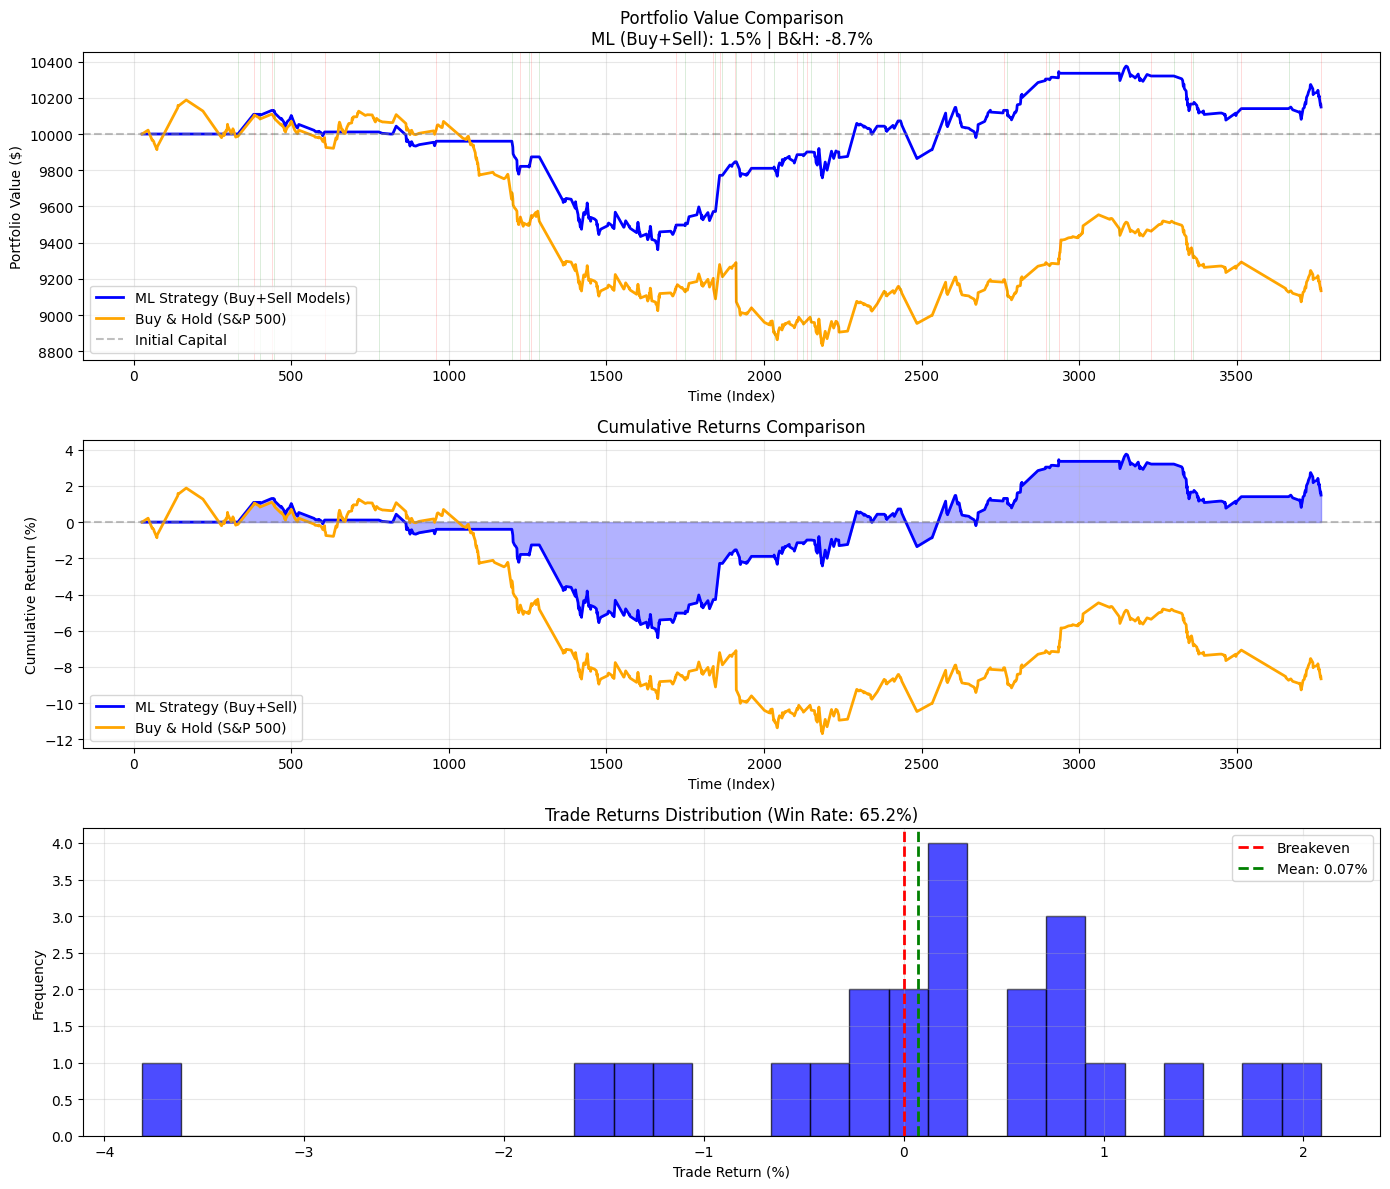

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration
COMBINED_PREDICTIONS_PATH = "./output/model_results/combined_predictions.csv"
# SP500_DATA_PATH = "./output/testing_bs_features/^GSPC_testing_dataset_23.4.2-4.30.csv"
SP500_DATA_PATH = "./output/testing_bs_features/SPY_testing_dataset_22.6.2-6.30.csv"
OUTPUT_DIR = "./output/backtest_results"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Strategy parameters
PROFIT_THRESHOLD_BUY = 2   # Buy threshold
PROFIT_THRESHOLD_SELL = 2  # Sell threshold (can be different!)
POSITION_SIZE = 1            # Use 100% of capital per trade
INITIAL_CAPITAL = 10000

print("=" * 80)
print("Portfolio Backtesting: Separate Buy/Sell Models vs Buy & Hold")
print("=" * 80)

# Load predictions from separate models
print("\n[1/5] Loading model predictions...")
df_signals = pd.read_csv(COMBINED_PREDICTIONS_PATH)

# Load full S&P 500 data for buy & hold
print("[2/5] Loading S&P 500 historical data...")
df_sp500 = pd.read_csv(SP500_DATA_PATH)
df_sp500 = df_sp500.sort_values('klu_idx').reset_index(drop=True)

# Sort signals by timestamp to ensure chronological order
df_signals = df_signals.sort_values('klu_idx').reset_index(drop=True)

# Get test period range (from signals)
test_start_idx = df_signals['klu_idx'].min()
test_end_idx = df_signals['klu_idx'].max()

# Filter S&P 500 data to test period
df_sp500_test = df_sp500[
    (df_sp500['klu_idx'] >= test_start_idx) & 
    (df_sp500['klu_idx'] <= test_end_idx)
].reset_index(drop=True)

print(f"S&P 500 data points in test period: {len(df_sp500_test)}")
print(f"ML signals in test period: {len(df_signals)}")
print(f"  - Buy signals:  {len(df_signals[df_signals['direction'] == 'buy'])}")
print(f"  - Sell signals: {len(df_signals[df_signals['direction'] == 'sell'])}")
print(f"Date range: {df_sp500_test['timestamp'].min()} to {df_sp500_test['timestamp'].max()}")

# Initialize portfolios
print("\n[3/5] Running backtest with separate models...")

# ML Strategy Portfolio
ml_capital = INITIAL_CAPITAL
ml_cash = INITIAL_CAPITAL
ml_shares = 0  # Number of shares held
ml_entry_price = 0
ml_trades = []
ml_returns = []
ml_skipped_sells = 0  # Track skipped sell signals
ml_skipped_buys = 0   # Track skipped buy signals

# Create a dictionary to map klu_idx to ML portfolio value
ml_portfolio_by_idx = {}

# Buy & Hold Portfolio (using full S&P 500 data)
bh_entry_price = df_sp500_test.iloc[0]['klu_close']
bh_shares = INITIAL_CAPITAL / bh_entry_price
bh_portfolio_values = []

# Calculate Buy & Hold for entire test period
for idx, row in df_sp500_test.iterrows():
    bh_portfolio_value = bh_shares * row['klu_close']
    bh_portfolio_values.append(bh_portfolio_value)

# Process ML signals using separate model predictions
for idx, row in df_signals.iterrows():
    current_price = row['klu_close']
    predicted_profit = row['predicted_profit_pct']  # Already from correct model!
    actual_profit = row['profit_target_pct']
    direction = row['direction']
    
    # Select threshold based on direction
    threshold = PROFIT_THRESHOLD_BUY if direction == 'buy' else PROFIT_THRESHOLD_SELL
    
    # === ML Strategy Logic ===
    
    if direction == 'buy' and ml_shares == 0:
        # BUY signal: Enter position if buy model predicts profit > buy threshold
        if predicted_profit >= PROFIT_THRESHOLD_BUY:
            trade_capital = ml_cash * POSITION_SIZE
            ml_shares = trade_capital / current_price
            ml_entry_price = current_price
            ml_cash -= trade_capital
            
            ml_trades.append({
                'entry_idx': idx,
                'entry_klu_idx': row['klu_idx'],
                'entry_timestamp': row['timestamp'],
                'direction': 'buy',
                'entry_price': current_price,
                'predicted_profit': predicted_profit,
                'position_size': trade_capital,
                'shares': ml_shares,
                'model_used': 'buy_model'
            })
        else:
            ml_skipped_buys += 1
    
    elif direction == 'sell' and ml_shares > 0:
        # SELL signal: Exit position if sell model predicts profit > sell threshold
        if predicted_profit >= PROFIT_THRESHOLD_SELL:
            exit_value = ml_shares * current_price
            trade_profit = exit_value - (ml_shares * ml_entry_price)
            trade_return_pct = (trade_profit / (ml_shares * ml_entry_price)) * 100
            
            ml_cash += exit_value
            
            # Record trade result
            if ml_trades:
                ml_trades[-1].update({
                    'exit_idx': idx,
                    'exit_klu_idx': row['klu_idx'],
                    'exit_timestamp': row['timestamp'],
                    'exit_price': current_price,
                    'exit_predicted_profit': predicted_profit,
                    'actual_profit': actual_profit,
                    'trade_profit': trade_profit,
                    'trade_return_pct': trade_return_pct,
                    'model_used_exit': 'sell_model'
                })
                ml_returns.append(trade_return_pct)
            
            # Reset position
            ml_shares = 0
            ml_entry_price = 0
        else:
            # Skip this sell signal (sell model predicts insufficient profit)
            ml_skipped_sells += 1
    
    # Calculate current portfolio value
    position_value = ml_shares * current_price
    ml_portfolio_value = ml_cash + position_value
    
    # Store by klu_idx for later mapping
    ml_portfolio_by_idx[row['klu_idx']] = ml_portfolio_value

# Close any open position at the end
if ml_shares > 0:
    final_price = df_signals.iloc[-1]['klu_close']
    exit_value = ml_shares * final_price
    trade_profit = exit_value - (ml_shares * ml_entry_price)
    trade_return_pct = (trade_profit / (ml_shares * ml_entry_price)) * 100
    
    ml_cash += exit_value
    
    if ml_trades:
        ml_trades[-1].update({
            'exit_idx': len(df_signals) - 1,
            'exit_klu_idx': df_signals.iloc[-1]['klu_idx'],
            'exit_timestamp': df_signals.iloc[-1]['timestamp'],
            'exit_price': final_price,
            'exit_predicted_profit': None,
            'actual_profit': None,
            'trade_profit': trade_profit,
            'trade_return_pct': trade_return_pct,
            'note': 'Closed at end of period'
        })
        ml_returns.append(trade_return_pct)
    
    ml_portfolio_by_idx[df_signals.iloc[-1]['klu_idx']] = ml_cash

# Map ML portfolio values to full timeline (forward-fill for dates without signals)
ml_portfolio_values = []
last_ml_value = INITIAL_CAPITAL
for idx, row in df_sp500_test.iterrows():
    klu_idx = row['klu_idx']
    if klu_idx in ml_portfolio_by_idx:
        last_ml_value = ml_portfolio_by_idx[klu_idx]
    ml_portfolio_values.append(last_ml_value)

# Add portfolio values to full S&P 500 dataframe
df_sp500_test['ml_portfolio_value'] = ml_portfolio_values
df_sp500_test['bh_portfolio_value'] = bh_portfolio_values

# Calculate metrics
print("\n[4/5] Calculating performance metrics...")

# ML Strategy Metrics
ml_final_value = ml_portfolio_values[-1]
ml_total_return = ((ml_final_value - INITIAL_CAPITAL) / INITIAL_CAPITAL) * 100
ml_completed_trades = len([t for t in ml_trades if 'exit_price' in t])
ml_winning_trades = len([t for t in ml_trades if 'trade_profit' in t and t['trade_profit'] > 0])
ml_win_rate = (ml_winning_trades / ml_completed_trades * 100) if ml_completed_trades > 0 else 0

# Buy & Hold Metrics
bh_final_value = bh_portfolio_values[-1]
bh_total_return = ((bh_final_value - INITIAL_CAPITAL) / INITIAL_CAPITAL) * 100

# Calculate max drawdown for ML strategy
ml_peak = INITIAL_CAPITAL
ml_max_drawdown = 0
for value in ml_portfolio_values:
    if value > ml_peak:
        ml_peak = value
    drawdown = ((ml_peak - value) / ml_peak) * 100
    if drawdown > ml_max_drawdown:
        ml_max_drawdown = drawdown

# Print results
print("\n" + "=" * 80)
print("BACKTEST RESULTS")
print("=" * 80)

print(f"\nInitial Capital: ${INITIAL_CAPITAL:,.2f}")
print(f"Trading Period: {df_sp500_test['timestamp'].min()} to {df_sp500_test['timestamp'].max()}")
print(f"Total Days: {len(df_sp500_test)}")
print(f"Total ML Signals: {len(df_signals)}")
print(f"Buy & Hold using: Full S&P 500 daily prices")

print("\n" + "-" * 80)
print("ML TRADING STRATEGY (Separate Buy/Sell Models)")
print("-" * 80)
print(f"Strategy: Use BUY model for entries, SELL model for exits")
print(f"  - Buy Threshold:  {PROFIT_THRESHOLD_BUY}% (from buy_model)")
print(f"  - Sell Threshold: {PROFIT_THRESHOLD_SELL}% (from sell_model)")
print(f"Position Size: {POSITION_SIZE*100}% per trade")
print(f"Final Portfolio Value: ${ml_final_value:,.2f}")
print(f"Total Return: {ml_total_return:.2f}%")
print(f"Max Drawdown: {ml_max_drawdown:.2f}%")
print(f"Total Trades: {len(ml_trades)} (Completed: {ml_completed_trades})")
print(f"Winning Trades: {ml_winning_trades}/{ml_completed_trades} ({ml_win_rate:.1f}%)")
print(f"Skipped Buy Signals: {ml_skipped_buys} (buy model predicted < {PROFIT_THRESHOLD_BUY}%)")
print(f"Skipped Sell Signals: {ml_skipped_sells} (sell model predicted < {PROFIT_THRESHOLD_SELL}%)")

if ml_returns:
    print(f"Average Trade Return: {np.mean(ml_returns):.2f}%")
    print(f"Median Trade Return: {np.median(ml_returns):.2f}%")
    print(f"Best Trade: {max(ml_returns):.2f}%")
    print(f"Worst Trade: {min(ml_returns):.2f}%")
    if len(ml_returns) > 1:
        print(f"Sharpe Ratio (approx): {np.mean(ml_returns) / np.std(ml_returns):.2f}")
        winning_returns = [r for r in ml_returns if r > 0]
        losing_returns = [r for r in ml_returns if r < 0]
        if winning_returns and losing_returns:
            print(f"Win/Loss Ratio: {np.mean(winning_returns) / abs(np.mean(losing_returns)):.2f}")

print("\n" + "-" * 80)
print("BUY & HOLD STRATEGY")
print("-" * 80)
print(f"Strategy: Buy at first day, hold until last day")
print(f"Entry Price: ${bh_entry_price:.2f}")
print(f"Final Price: ${df_sp500_test.iloc[-1]['klu_close']:.2f}")
print(f"Shares Held: {bh_shares:.4f}")
print(f"Final Portfolio Value: ${bh_final_value:,.2f}")
print(f"Total Return: {bh_total_return:.2f}%")

print("\n" + "-" * 80)
print("COMPARISON")
print("-" * 80)
print(f"ML Strategy vs Buy & Hold: {ml_total_return - bh_total_return:+.2f}%")
print(f"ML Strategy Outperformance: {((ml_final_value / bh_final_value - 1) * 100):+.2f}%")

if ml_total_return > bh_total_return:
    print(f"\n✅ The ML strategy OUTPERFORMED buy & hold!")
else:
    print(f"\n⚠️ The ML strategy UNDERPERFORMED buy & hold.")

# Visualizations
print("\n[5/5] Generating visualizations...")

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Portfolio Value Over Time
axes[0].plot(df_sp500_test['klu_idx'], df_sp500_test['ml_portfolio_value'], 
             label='ML Strategy (Buy+Sell Models)', linewidth=2, color='blue')
axes[0].plot(df_sp500_test['klu_idx'], df_sp500_test['bh_portfolio_value'], 
             label='Buy & Hold (S&P 500)', linewidth=2, color='orange')
axes[0].axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')

# Mark trades on signal days
for trade in ml_trades:
    entry_klu_idx = trade['entry_klu_idx']
    axes[0].axvline(x=entry_klu_idx, color='green', alpha=0.2, linewidth=0.5)
    if 'exit_klu_idx' in trade:
        exit_klu_idx = trade['exit_klu_idx']
        axes[0].axvline(x=exit_klu_idx, color='red', alpha=0.2, linewidth=0.5)

axes[0].set_xlabel('Time (Index)')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].set_title(f'Portfolio Value Comparison\nML (Buy+Sell): {ml_total_return:.1f}% | B&H: {bh_total_return:.1f}%')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Cumulative Returns
ml_returns_series = (df_sp500_test['ml_portfolio_value'] / INITIAL_CAPITAL - 1) * 100
bh_returns_series = (df_sp500_test['bh_portfolio_value'] / INITIAL_CAPITAL - 1) * 100

axes[1].plot(df_sp500_test['klu_idx'], ml_returns_series, 
             label='ML Strategy (Buy+Sell)', linewidth=2, color='blue')
axes[1].plot(df_sp500_test['klu_idx'], bh_returns_series, 
             label='Buy & Hold (S&P 500)', linewidth=2, color='orange')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].fill_between(df_sp500_test['klu_idx'], ml_returns_series, 0, alpha=0.3, color='blue')
axes[1].set_xlabel('Time (Index)')
axes[1].set_ylabel('Cumulative Return (%)')
axes[1].set_title('Cumulative Returns Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Trade Distribution
if ml_returns:
    axes[2].hist(ml_returns, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Breakeven')
    axes[2].axvline(x=np.mean(ml_returns), color='green', linestyle='--', linewidth=2, 
                    label=f'Mean: {np.mean(ml_returns):.2f}%')
    axes[2].set_xlabel('Trade Return (%)')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title(f'Trade Returns Distribution (Win Rate: {ml_win_rate:.1f}%)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/backtest_separate_models.png", dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/backtest_separate_models.png")

# Save detailed trade log
if ml_trades:
    trades_df = pd.DataFrame(ml_trades)
    trades_df.to_csv(f"{OUTPUT_DIR}/trade_log_separate_models.csv", index=False)
    print(f"Saved: {OUTPUT_DIR}/trade_log_separate_models.csv")
    
    print("\nSample trades:")
    display_cols = ['entry_timestamp', 'entry_price', 'exit_price', 
                   'predicted_profit', 'exit_predicted_profit', 'trade_return_pct']
    available_cols = [col for col in display_cols if col in trades_df.columns]
    print(trades_df[available_cols].head(10).to_string(index=False))

# Save summary report
with open(f"{OUTPUT_DIR}/backtest_separate_models_summary.txt", 'w') as f:
    f.write("Portfolio Backtesting Summary Report\n")
    f.write("Separate Buy/Sell Model Strategy\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("STRATEGY PARAMETERS:\n")
    f.write(f"  Buy Model Threshold:  {PROFIT_THRESHOLD_BUY}%\n")
    f.write(f"  Sell Model Threshold: {PROFIT_THRESHOLD_SELL}%\n")
    f.write(f"  Position Size: {POSITION_SIZE*100}%\n")
    f.write(f"  Initial Capital: ${INITIAL_CAPITAL:,.2f}\n")
    f.write("  Strategy: Use buy_model for entries, sell_model for exits\n")
    f.write("  Note: Entry uses buy model, exit uses sell model\n\n")
    
    f.write("DATA:\n")
    f.write(f"  Test Period: {df_sp500_test['timestamp'].min()} to {df_sp500_test['timestamp'].max()}\n")
    f.write(f"  Total Days: {len(df_sp500_test)}\n")
    f.write(f"  ML Signals: {len(df_signals)}\n")
    f.write(f"  Buy & Hold: Using full S&P 500 daily prices\n\n")
    
    f.write("ML TRADING STRATEGY (Separate Models):\n")
    f.write(f"  Final Value: ${ml_final_value:,.2f}\n")
    f.write(f"  Total Return: {ml_total_return:.2f}%\n")
    f.write(f"  Max Drawdown: {ml_max_drawdown:.2f}%\n")
    f.write(f"  Total Trades: {len(ml_trades)}\n")
    f.write(f"  Completed Trades: {ml_completed_trades}\n")
    f.write(f"  Win Rate: {ml_win_rate:.1f}%\n")
    f.write(f"  Skipped Buy Signals: {ml_skipped_buys}\n")
    f.write(f"  Skipped Sell Signals: {ml_skipped_sells}\n")
    if ml_returns:
        f.write(f"  Average Trade Return: {np.mean(ml_returns):.2f}%\n")
        f.write(f"  Median Trade Return: {np.median(ml_returns):.2f}%\n")
        f.write(f"  Best Trade: {max(ml_returns):.2f}%\n")
        f.write(f"  Worst Trade: {min(ml_returns):.2f}%\n")
    
    f.write("\nBUY & HOLD STRATEGY (S&P 500):\n")
    f.write(f"  Entry Price: ${bh_entry_price:.2f}\n")
    f.write(f"  Final Price: ${df_sp500_test.iloc[-1]['klu_close']:.2f}\n")
    f.write(f"  Final Value: ${bh_final_value:,.2f}\n")
    f.write(f"  Total Return: {bh_total_return:.2f}%\n")
    f.write(f"  Data Source: Full daily S&P 500 prices\n")
    
    f.write("\nCOMPARISON:\n")
    f.write(f"  ML vs B&H: {ml_total_return - bh_total_return:+.2f}%\n")
    f.write(f"  Outperformance: {((ml_final_value / bh_final_value - 1) * 100):+.2f}%\n")

print(f"Saved: {OUTPUT_DIR}/backtest_separate_models_summary.txt")

print("\n" + "=" * 80)
print("Backtesting Complete!")
print("=" * 80)

print(f"\nKey Takeaways:")
print(f"  - Buy & Hold uses full S&P 500 daily prices ({len(df_sp500_test)} days)")
print(f"  - ML Strategy made {ml_completed_trades} trades with {ml_win_rate:.1f}% win rate")
print(f"  - Uses SEPARATE models: buy_model for entries, sell_model for exits")
print(f"  - ML signals: {len(df_signals)} (only trade days with buy/sell signals)")
print(f"  - Average return per trade: {np.mean(ml_returns):.2f}%" if ml_returns else "  - No completed trades")
print(f"  - Skipped {ml_skipped_buys} buy signals (< {PROFIT_THRESHOLD_BUY}% threshold)")
print(f"  - Skipped {ml_skipped_sells} sell signals (< {PROFIT_THRESHOLD_SELL}% threshold)")
print(f"  - Position size: {POSITION_SIZE*100}% of capital per trade")

if ml_total_return > bh_total_return:
    print(f"\n🎯 Separate models strategy BEAT the market by {ml_total_return - bh_total_return:.2f}%!")
else:
    print(f"\n📊 Strategy needs improvement - underperformed by {abs(ml_total_return - bh_total_return):.2f}%")

plt.show()

In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
SPY BSPoint Backtesting System
Real-time backtesting using sliding window BSPoint detection
"""

import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import pickle
import argparse

# Set recursion limit for deep Chan calculations
sys.setrecursionlimit(30000)

# Extend SlidingWindowChan with BSPoint detection methods
def extend_sliding_window_chan():
    """Add BSPoint detection methods to SlidingWindowChan"""
    from sliding_window_chan import SlidingWindowChan
    
    def check_if_newest_kline_is_bspoint(self, lv):
        """
        Check if the newest kline in the window is a BSPoint
        
        Parameters:
        - lv: K-line level
        
        Returns:
        - Dictionary with BSPoint information if it is a BSPoint, None otherwise
        """
        if not hasattr(self, 'kl_datas') or lv not in self.kl_datas:
            return None
        
        # Get the BS point list
        bs_point_list = self.kl_datas[lv].bs_point_lst
        if not bs_point_list:
            return None
        
        # Get the newest kline in the window
        kl_list = self.kl_datas[lv].kl_list
        if not kl_list:
            return None
        
        newest_kline = kl_list[-1]
        newest_kline_idx = newest_kline.idx
        
        # Check if this kline is a BSPoint
        all_bspoints = bs_point_list.getSortedBspList()
        
        for bsp in all_bspoints:
            if bsp.klu.idx == newest_kline_idx:
                # Found a BSPoint at the newest kline - extract its information
                bsp_info = {
                    'is_bspoint': True,
                    'klu_idx': bsp.klu.idx,
                    'timestamp': bsp.klu.time,
                    'klu_close': bsp.klu.close,
                    'klu_open': bsp.klu.open,
                    'klu_high': bsp.klu.high,
                    'klu_low': bsp.klu.low,
                    'klu_volume': getattr(bsp.klu, 'volume', 0),
                    'is_buy': bsp.is_buy,
                    'bsp_type': bsp.type2str(),
                }
                
                # Add divergence rate if available
                if hasattr(bsp, 'divergence_rate'):
                    bsp_info['divergence_rate'] = bsp.divergence_rate
                
                # Extract features from the BSPoint
                if hasattr(bsp, 'features'):
                    feature_dict = {}
                    if hasattr(bsp.features, 'to_dict'):
                        feature_dict = bsp.features.to_dict()
                    else:
                        # Manually extract features from BSPoint object
                        for attr_name in dir(bsp.features):
                            if not attr_name.startswith('_') and attr_name != 'to_dict':
                                feature_dict[attr_name] = getattr(bsp.features, attr_name)
                    
                    bsp_info['features'] = feature_dict
                
                # Extract profit target if available
                if hasattr(bsp, 'profit_target_pct'):
                    bsp_info['profit_target_pct'] = bsp.profit_target_pct
                
                # Add additional technical indicators if available
                # Add MACD indicators
                if hasattr(newest_kline, 'macd'):
                    bsp_info['macd_value'] = getattr(newest_kline.macd, 'macd', None)
                    bsp_info['macd_dif'] = getattr(newest_kline.macd, 'DIF', None)
                    bsp_info['macd_dea'] = getattr(newest_kline.macd, 'DEA', None)
                    
                    # Calculate PPO (Percentage Price Oscillator) if fast_ema and slow_ema available
                    macd_fast = getattr(newest_kline.macd, 'fast_ema', None)
                    macd_slow = getattr(newest_kline.macd, 'slow_ema', None)
                    if macd_fast is not None and macd_slow is not None and macd_slow != 0:
                        bsp_info['ppo'] = (macd_fast - macd_slow) / macd_slow
                
                # Add KDJ indicators
                if hasattr(newest_kline, 'kdj'):
                    bsp_info['kdj_k'] = getattr(newest_kline.kdj, 'k', None)
                    bsp_info['kdj_d'] = getattr(newest_kline.kdj, 'd', None)
                    bsp_info['kdj_j'] = getattr(newest_kline.kdj, 'j', None)
                
                # Add RSI
                if hasattr(newest_kline, 'rsi'):
                    bsp_info['rsi'] = newest_kline.rsi
                
                return bsp_info
        
        # No BSPoint found at the newest kline
        return None
    
    def get_current_window_data(self, lv):
        """
        Get all the kline data currently in the sliding window for a specific level
        
        Parameters:
        - lv: K-line level
        
        Returns:
        - List of kline data dictionaries
        """
        if not hasattr(self, 'kl_datas') or lv not in self.kl_datas:
            return []
        
        # Get all klines in the current window
        klines = self.kl_datas[lv].kl_list
        
        # Convert to list of dictionaries for easier access
        result = []
        for kl in klines:
            kline_data = {
                'klu_idx': kl.idx,
                'timestamp': kl.time,
                'klu_open': kl.open,
                'klu_high': kl.high,
                'klu_low': kl.low,
                'klu_close': kl.close,
                'klu_volume': getattr(kl, 'volume', 0)
            }
            
            # Add other technical indicators if available
            if hasattr(kl, 'macd'):
                kline_data['macd_value'] = getattr(kl.macd, 'macd', None)
                kline_data['macd_dif'] = getattr(kl.macd, 'DIF', None)
                kline_data['macd_dea'] = getattr(kl.macd, 'DEA', None)
            
            if hasattr(kl, 'kdj'):
                kline_data['kdj_k'] = getattr(kl.kdj, 'k', None)
                kline_data['kdj_d'] = getattr(kl.kdj, 'd', None)
                kline_data['kdj_j'] = getattr(kl.kdj, 'j', None)
            
            if hasattr(kl, 'rsi'):
                kline_data['rsi'] = kl.rsi
            
            result.append(kline_data)
        
        return result
    
    def calculate_best_profit_target_24h(self, bsp, lv, lookforward_bars=288):
        """
        Calculate the best profit target within 24 hours (or specified number of bars)
        
        Parameters:
        - bsp: BSPoint object
        - lv: K-line level
        - lookforward_bars: Number of bars to look ahead (default: 288 for 5-min bars = 24 hours)
        
        Returns:
        - Dictionary with profit target information
        """
        if not bsp or not hasattr(self, 'kl_datas') or lv not in self.kl_datas:
            return None
        
        # Get BS point list
        bs_point_list = self.kl_datas[lv].bs_point_lst
        if not bs_point_list:
            return None
        
        # Get all BSPoints
        all_bspoints = bs_point_list.getSortedBspList()
        
        # Find BSPoint index
        bsp_idx = -1
        for i, point in enumerate(all_bspoints):
            if point.klu.idx == bsp.klu.idx and point.is_buy == bsp.is_buy:
                bsp_idx = i
                break
        
        if bsp_idx == -1:
            return None
        
        current_direction = bsp.is_buy
        entry_price = bsp.klu.close
        entry_idx = bsp.klu.idx
        
        # Initialize
        profit_target = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window end index
        window_end_idx = entry_idx + lookforward_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(bsp_idx + 1, len(all_bspoints)):
            future_bsp = all_bspoints[j]
            future_idx = future_bsp.klu.idx
            
            # Check if opposite direction
            if future_bsp.is_buy != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_bsp
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_bsp)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x.klu.close)
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x.klu.close)
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            return profit_target
        
        # Calculate profit percentage
        exit_price = best_exit.klu.close
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_target = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit.klu.idx - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit.klu.idx,
            'exit_price': exit_price,
        }
        
        return profit_target
    
    def export_current_bspoint_to_dict(self, bsp, bi_list=None):
        """
        Export a BS point to a dictionary with all available features
        
        Parameters:
        - bsp: BSPoint object
        - bi_list: List of bi objects for additional features (optional)
        
        Returns:
        - Dictionary with BSPoint features
        """
        if not bsp:
            return None
        
        # Base BSPoint information
        bsp_dict = {
            'klu_idx': bsp.klu.idx,
            'timestamp': bsp.klu.time,
            'klu_open': bsp.klu.open,
            'klu_high': bsp.klu.high,
            'klu_low': bsp.klu.low,
            'klu_close': bsp.klu.close,
            'klu_volume': getattr(bsp.klu, 'volume', 0),
            'bsp_type': bsp.type2str(),
            'bsp_types': ','.join([str(t.value) for t in bsp.type]),
            'is_buy': 1 if bsp.is_buy else 0,
            'direction': 'buy' if bsp.is_buy else 'sell',
        }
        
        # Add divergence rate if available
        if hasattr(bsp, 'divergence_rate'):
            bsp_dict['divergence_rate'] = bsp.divergence_rate
        
        # Add bi_idx if available
        if hasattr(bsp, 'bi') and bsp.bi:
            bsp_dict['bi_idx'] = bsp.bi.idx
        
        # Add features from the BSPoint object
        if hasattr(bsp, 'features'):
            if hasattr(bsp.features, 'to_dict'):
                feature_dict = bsp.features.to_dict()
                for key, value in feature_dict.items():
                    # Add prefix 'feat_' to feature names
                    feat_key = f'feat_{key}' if not key.startswith('feat_') else key
                    bsp_dict[feat_key] = value
            else:
                # Manually extract features
                for attr_name in dir(bsp.features):
                    if not attr_name.startswith('_') and attr_name != 'to_dict':
                        feat_key = f'feat_{attr_name}' if not attr_name.startswith('feat_') else attr_name
                        bsp_dict[feat_key] = getattr(bsp.features, attr_name)
        
        # Add technical indicators from the kline
        klu = bsp.klu
        
        # Add MACD indicators
        if hasattr(klu, 'macd'):
            bsp_dict['macd_value'] = getattr(klu.macd, 'macd', None)
            bsp_dict['macd_dif'] = getattr(klu.macd, 'DIF', None)
            bsp_dict['macd_dea'] = getattr(klu.macd, 'DEA', None)
            
            # Add MACD signal (1 if DIF > DEA, 0 otherwise)
            if hasattr(klu.macd, 'DIF') and hasattr(klu.macd, 'DEA'):
                dif_value = getattr(klu.macd, 'DIF', 0)
                dea_value = getattr(klu.macd, 'DEA', 0)
                if dif_value is not None and dea_value is not None:
                    bsp_dict['macd_signal'] = 1 if dif_value > dea_value else 0
            
            # Calculate PPO if possible
            macd_fast = getattr(klu.macd, 'fast_ema', None)
            macd_slow = getattr(klu.macd, 'slow_ema', None)
            if macd_fast is not None and macd_slow is not None and macd_slow != 0:
                bsp_dict['ppo'] = (macd_fast - macd_slow) / macd_slow
        
        # Add KDJ indicators
        if hasattr(klu, 'kdj'):
            bsp_dict['kdj_k'] = getattr(klu.kdj, 'k', None)
            bsp_dict['kdj_d'] = getattr(klu.kdj, 'd', None)
            bsp_dict['kdj_j'] = getattr(klu.kdj, 'j', None)
        
        # Add RSI if available
        if hasattr(klu, 'rsi'):
            bsp_dict['rsi'] = klu.rsi
        
        return bsp_dict
    
    # Add methods to SlidingWindowChan class
    SlidingWindowChan.check_if_newest_kline_is_bspoint = check_if_newest_kline_is_bspoint
    SlidingWindowChan.get_current_window_data = get_current_window_data
    SlidingWindowChan.calculate_best_profit_target_24h = calculate_best_profit_target_24h
    SlidingWindowChan.export_current_bspoint_to_dict = export_current_bspoint_to_dict
    
    print("[✓] Extended SlidingWindowChan with BSPoint detection methods")


class BSPointBacktester:
    """
    BSPoint backtester using sliding window approach
    """
    def __init__(self, model_path=None, profit_threshold=0.005, lookback_window=500):
        """
        Initialize the BSPoint backtester
        
        Parameters:
        - model_path: Path to pre-trained model file (optional)
        - profit_threshold: Profit threshold for trading (default: 0.5%)
        - lookback_window: Size of lookback window (default: 500)
        """
        self.model_path = model_path
        self.profit_threshold = profit_threshold
        self.lookback_window = lookback_window
        self.model = None
        self.feature_cols = None
        self.trades = []
        self.signals = []
        
        # Load model if provided
        if model_path and os.path.exists(model_path):
            self.load_model(model_path)
    
    def load_model(self, model_path):
        """Load pre-trained model"""
        try:
            with open(model_path, 'rb') as f:
                self.model = pickle.load(f)
            print(f"[✓] Loaded model from {model_path}")
            return True
        except Exception as e:
            print(f"[✗] Error loading model: {e}")
            return False
    
    def save_model(self, model_path):
        """Save trained model"""
        if self.model is None:
            print("[✗] No model to save")
            return False
        
        try:
            with open(model_path, 'wb') as f:
                pickle.dump(self.model, f)
            print(f"[✓] Saved model to {model_path}")
            return True
        except Exception as e:
            print(f"[✗] Error saving model: {e}")
            return False
    
    def prepare_features(self, training_data):
        """Extract relevant features from training data"""
        # Select features based on patterns
        feature_patterns = [
            'feat_', 'macd_', 'rsi', 'kdj_', 'dmi_', 'sma_', 'price_above_', 
            'ema_', 'atr', 'stoch_', 'roc_', 'williams_', 'cci', 'mfi', 'tsi', 
            'uo', 'psar', 'candle_', 'volume_', 'price_change'
        ]
        
        feature_cols = []
        for pattern in feature_patterns:
            feature_cols.extend([col for col in training_data.columns if pattern in col])
        
        # Add price features
        price_features = [
            'klu_open', 'klu_high', 'klu_low', 'klu_close', 'klu_volume',
            'high_low_spread_pct', 'upper_shadow', 'lower_shadow', 'body_size', 
            'is_bullish_candle', 'volume_price_trend'
        ]
        
        for feat in price_features:
            if feat in training_data.columns:
                feature_cols.append(feat)
        
        # Remove duplicates and sort
        self.feature_cols = sorted(list(set(feature_cols)))
        print(f"[✓] Selected {len(self.feature_cols)} features for model")
        
        # Print some feature examples
        if len(self.feature_cols) > 0:
            print(f"[ℹ] Feature examples: {', '.join(self.feature_cols[:5])}...")
        
        return self.feature_cols
    
    def train_model(self, training_data, target='label_10', test_size=0.2, random_state=42):
        """Train machine learning model on BSPoint data"""
        from sklearn.model_selection import train_test_split
        
        # Filter to only include actual BSPoints
        bsp_data = training_data[training_data['bsp_type'].notna()]
        print(f"[ℹ] Training on {len(bsp_data)} BSPoints out of {len(training_data)} total points")
        
        # Prepare features if not already done
        if not self.feature_cols:
            self.prepare_features(training_data)
        
        # Check if all features exist in the data
        missing_features = [col for col in self.feature_cols if col not in bsp_data.columns]
        if missing_features:
            print(f"[⚠] Warning: {len(missing_features)} features are missing from the data")
            self.feature_cols = [col for col in self.feature_cols if col in bsp_data.columns]
            print(f"[ℹ] Using {len(self.feature_cols)} available features")
        
        # Prepare data
        X = bsp_data[self.feature_cols].fillna(0)
        y = bsp_data[target].fillna(0)
        
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Train model
        print("[⏳] Training random forest model...")
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=10,
            random_state=random_state,
            n_jobs=-1
        )
        
        self.model.fit(X_train, y_train)
        
        # Evaluate model
        train_acc = self.model.score(X_train, y_train)
        test_acc = self.model.score(X_test, y_test)
        
        print(f"[✓] Model training complete")
        print(f"[ℹ] Train accuracy: {train_acc:.4f}")
        print(f"[ℹ] Test accuracy: {test_acc:.4f}")
        
        # Get feature importance
        importances = pd.DataFrame({
            'feature': self.feature_cols,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("[ℹ] Top 10 important features:")
        for i, row in importances.head(10).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")
        
        return self.model
    
    def run_backtest(self, ticker, begin_time, end_time, training_data=None, chan_config=None, max_klines=1000, data_file=None):
        """
        Run backtest using sliding window Chan system
        
        Parameters:
        - ticker: Ticker symbol
        - begin_time: Start date for backtest
        - end_time: End date for backtest
        - training_data: Training data for model (optional)
        - chan_config: Chan system configuration (optional)
        - max_klines: Maximum klines in sliding window (default: 1000)
        - data_file: Path to price data file (optional)
        
        Returns:
        - Dictionary with backtest results
        """
        from ChanConfig import CChanConfig
        from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE
        from sliding_window_chan import SlidingWindowChan
        
        # Train model if not loaded and training data is provided
        if self.model is None and training_data is not None:
            self.train_model(training_data)
        
        # Check if model is available
        if self.model is None:
            raise ValueError("Model must be trained or loaded before backtesting")
        
        # Reset state
        self.trades = []
        self.signals = []
        
        # Default Chan configuration
        if chan_config is None:
            chan_config = CChanConfig({
                "cal_demark": True,
                "cal_kdj": True,
                "cal_dmi": True,
                "cal_rsi": True,
                "cal_macd": True,
                "cal_bb_vals": True,
                "bi_strict": True,
                "trigger_step": True,
                "skip_step": 0,
                "divergence_rate": float("inf"),
                "bsp2_follow_1": True,
                "bsp3_follow_1": False,
                "min_zs_cnt": 0,
                "bs1_peak": False,
                "macd_algo": "peak",
                "bs_type": '1,2,3a,1p,2s,3b',
                "print_warning": False,
                "zs_algo": "normal",
            })
        
        # Create sliding window Chan
        lv = KL_TYPE.K_5M
        lv_list = [lv]
        
        print(f"[⏳] Creating sliding window Chan for {ticker} from {begin_time} to {end_time}")
        print(f"[ℹ] Window size: {max_klines} klines")
        print(f"[ℹ] Profit threshold: {self.profit_threshold*100:.2f}%")
        
        try:
            # Determine data source
            data_source = DATA_SRC.CSV
            
            # If data_file is provided, override data source configuration
            if data_file:
                print(f"[ℹ] Using data file: {data_file}")
                # Set up custom data source path
                import os
                os.environ['CSV_PATH'] = os.path.dirname(data_file)
                
                # Use filename without extension as the ticker
                ticker_override = os.path.splitext(os.path.basename(data_file))[0]
                print(f"[ℹ] Using ticker from filename: {ticker_override}")
                
                # Create Chan with custom data source
                chan = SlidingWindowChan(
                    code=ticker_override,
                    begin_time=begin_time,
                    end_time=end_time,
                    data_src=data_source,
                    lv_list=lv_list,
                    config=chan_config,
                    autype=AUTYPE.QFQ,
                    max_klines=max_klines
                )
            else:
                # Create Chan with default data source
                chan = SlidingWindowChan(
                    code=ticker,
                    begin_time=begin_time,
                    end_time=end_time,
                    data_src=data_source,
                    lv_list=lv_list,
                    config=chan_config,
                    autype=AUTYPE.QFQ,
                    max_klines=max_klines
                )
        except Exception as e:
            print(f"[✗] Error creating sliding window Chan: {e}")
            return {
                'error': str(e),
                'num_trades': 0,
                'trades': [],
                'signals': []
            }
        
        # Process each snapshot
        print(f"[⏳] Running backtest...")
        snapshot_count = 0
        active_position = None
        
        # Progress tracking
        snapshot_count = 0
        signal_count = 0
        trade_count = 0
        last_progress_time = datetime.now()
        
        # Process each step
        for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
            snapshot_count = snapshot_idx + 1
            
            # Check if the newest kline is a BSPoint
            bsp_info = chan.check_if_newest_kline_is_bspoint(lv)
            
            if bsp_info and bsp_info.get('is_bspoint', False):
                # Extract features for prediction
                feature_values = {}
                
                # First, extract from features dictionary if available
                if 'features' in bsp_info:
                    for feature, value in bsp_info['features'].items():
                        feature_values[f"feat_{feature}"] = value
                
                # Add other features from bsp_info
                feature_values.update({
                    'klu_open': bsp_info.get('klu_open', 0),
                    'klu_high': bsp_info.get('klu_high', 0),
                    'klu_low': bsp_info.get('klu_low', 0),
                    'klu_close': bsp_info.get('klu_close', 0),
                    'klu_volume': bsp_info.get('klu_volume', 0),
                    'macd_value': bsp_info.get('macd_value', 0),
                    'macd_dif': bsp_info.get('macd_dif', 0),
                    'macd_dea': bsp_info.get('macd_dea', 0),
                    'kdj_k': bsp_info.get('kdj_k', 0),
                    'kdj_d': bsp_info.get('kdj_d', 0),
                    'kdj_j': bsp_info.get('kdj_j', 0),
                    'rsi': bsp_info.get('rsi', 0),
                })
                
                # Prepare feature vector
                X = pd.DataFrame([feature_values])
                
                # Fill missing features with zeros
                for col in self.feature_cols:
                    if col not in X.columns:
                        X[col] = 0
                
                # Select only the required features in the correct order
                X = X[self.feature_cols].fillna(0)
                
                # Make prediction
                probability = self.model.predict_proba(X)[0][1]
                prediction_positive = probability > 0.5
                
                # Calculate profit target
                profit_target = chan.calculate_best_profit_target_24h(bsp_info, lv, lookforward_bars=288)
                profit_potential = profit_target.get('profit_target_pct', 0) if profit_target else 0
                meets_threshold = profit_potential >= self.profit_threshold * 100  # Convert to percentage
                
                # Extract other BSPoint information
                is_buy = bsp_info.get('is_buy', True)
                bsp_type = bsp_info.get('bsp_type', 'unknown')
                close_price = bsp_info.get('klu_close', 0)
                timestamp = bsp_info.get('timestamp', None)
                klu_idx = bsp_info.get('klu_idx', snapshot_idx)
                
                # Record signal
                signal = {
                    'timestamp': timestamp,
                    'klu_idx': klu_idx,
                    'price': close_price,
                    'bsp_type': bsp_type,
                    'is_buy': is_buy,
                    'probability': probability,
                    'prediction': prediction_positive,
                    'profit_potential': profit_potential,
                    'meets_threshold': meets_threshold,
                    'signal': prediction_positive and meets_threshold
                }
                self.signals.append(signal)
                signal_count += 1
                
                # Generate trade signal if conditions are met
                if prediction_positive and meets_threshold:
                    # Handle existing position if any
                    if active_position is not None:
                        # Close position if signal is in opposite direction
                        if active_position['is_buy'] != is_buy:
                            exit_price = close_price
                            entry_price = active_position['entry_price']
                            
                            if active_position['is_buy']:  # Long position
                                pnl = (exit_price - entry_price) / entry_price
                            else:  # Short position
                                pnl = (entry_price - exit_price) / entry_price
                            
                            # Record the trade
                            trade = {
                                'entry_date': active_position['entry_date'],
                                'exit_date': timestamp,
                                'entry_idx': active_position['entry_idx'],
                                'exit_idx': klu_idx,
                                'entry_price': entry_price,
                                'exit_price': exit_price,
                                'is_buy': active_position['is_buy'],
                                'bsp_type': active_position['bsp_type'],
                                'pnl': pnl,
                                'duration': (timestamp - active_position['entry_date']).total_seconds() / 86400 if timestamp and active_position['entry_date'] else 0
                            }
                            self.trades.append(trade)
                            trade_count += 1
                            active_position = None
                    
                    # Open new position if none exists
                    if active_position is None:
                        active_position = {
                            'entry_date': timestamp,
                            'entry_idx': klu_idx,
                            'entry_price': close_price,
                            'is_buy': is_buy,
                            'bsp_type': bsp_type
                        }
            
            # Print progress periodically
            now = datetime.now()
            if snapshot_idx % 100 == 0 or (now - last_progress_time).total_seconds() > 5:
                print(f"[📊] Processed {snapshot_count} snapshots, {signal_count} signals, {trade_count} trades")
                last_progress_time = now
        
        # Close any remaining position at the end of the backtest
        if active_position is not None:
            # Get the last kline data
            last_window_data = chan.get_current_window_data(lv)
            if last_window_data and len(last_window_data) > 0:
                last_kline = last_window_data[-1]
                exit_price = last_kline.get('klu_close', 0)
                exit_timestamp = last_kline.get('timestamp', None)
                exit_idx = last_kline.get('klu_idx', snapshot_count)
                
                entry_price = active_position['entry_price']
                
                if active_position['is_buy']:  # Long position
                    pnl = (exit_price - entry_price) / entry_price
                else:  # Short position
                    pnl = (entry_price - exit_price) / entry_price
                
                # Record the final trade
                trade = {
                    'entry_date': active_position['entry_date'],
                    'exit_date': exit_timestamp,
                    'entry_idx': active_position['entry_idx'],
                    'exit_idx': exit_idx,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'is_buy': active_position['is_buy'],
                    'bsp_type': active_position['bsp_type'],
                    'pnl': pnl,
                    'duration': (exit_timestamp - active_position['entry_date']).total_seconds() / 86400 if exit_timestamp and active_position['entry_date'] else 0
                }
                self.trades.append(trade)
        
        # Generate performance report
        report = self._generate_performance_report()
        print(f"[✓] Backtest complete: {snapshot_count} snapshots processed")
        
        return report
    
    def _generate_performance_report(self):
        """Generate performance report from backtest results"""
        if not self.trades:
            print("[ℹ] No trades executed during backtest")
            return {
                'num_trades': 0,
                'win_rate': 0,
                'avg_pnl': 0,
                'total_return': 0,
                'trades': self.trades,
                'signals': self.signals
            }
        
        # Convert to DataFrames
        trades_df = pd.DataFrame(self.trades)
        signals_df = pd.DataFrame(self.signals)
        
        # Calculate metrics
        num_trades = len(trades_df)
        win_rate = len(trades_df[trades_df['pnl'] > 0]) / num_trades if num_trades > 0 else 0
        avg_pnl = trades_df['pnl'].mean() if num_trades > 0 else 0
        total_return = (1 + trades_df['pnl']).prod() - 1 if num_trades > 0 else 0
        avg_duration = trades_df['duration'].mean() if 'duration' in trades_df and num_trades > 0 else 0
        
        # Calculate metrics by BS point type
        bsp_type_performance = {}
        if 'bsp_type' in trades_df.columns and num_trades > 0:
            for bsp_type in trades_df['bsp_type'].unique():
                type_trades = trades_df[trades_df['bsp_type'] == bsp_type]
                if len(type_trades) == 0:
                    continue
                    
                type_win_rate = len(type_trades[type_trades['pnl'] > 0]) / len(type_trades)
                type_avg_pnl = type_trades['pnl'].mean()
                
                bsp_type_performance[bsp_type] = {
                    'num_trades': len(type_trades),
                    'win_rate': type_win_rate,
                    'avg_pnl': type_avg_pnl
                }
        
        # Print performance summary
        print("\n📊 BACKTEST RESULTS 📊")
        print("=" * 40)
        print(f"Number of trades:      {num_trades}")
        print(f"Win rate:              {win_rate:.2%}")
        print(f"Average P&L per trade: {avg_pnl:.2%}")
        print(f"Total return:          {total_return:.2%}")
        if avg_duration:
            print(f"Average trade duration: {avg_duration:.1f} days")
        
        if bsp_type_performance:
            print("\nPerformance by BSPoint type:")
            for bsp_type, metrics in bsp_type_performance.items():
                print(f"  {bsp_type}: {metrics['num_trades']} trades, {metrics['win_rate']:.2%} win rate, {metrics['avg_pnl']:.2%} avg P&L")
        
        # Prepare the report
        report = {
            'num_trades': num_trades,
            'win_rate': win_rate,
            'avg_pnl': avg_pnl,
            'total_return': total_return,
            'avg_duration': avg_duration if avg_duration else None,
            'bsp_type_performance': bsp_type_performance,
            'trades': self.trades,
            'signals': self.signals,
            'trades_df': trades_df,
            'signals_df': signals_df
        }
        
        return report
    
    def visualize_results(self, price_data=None):
        """
        Visualize backtest results
        
        Parameters:
        - price_data: DataFrame with price data (optional)
        
        Returns:
        - Matplotlib figure
        """
        # Convert trades and signals to DataFrames if they're not already
        if isinstance(self.trades, list):
            trades_df = pd.DataFrame(self.trades)
        else:
            trades_df = self.trades
        
        if isinstance(self.signals, list):
            signals_df = pd.DataFrame(self.signals)
        else:
            signals_df = self.signals
        
        if len(trades_df) == 0:
            print("[⚠] No trades to visualize")
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, "No trades executed during backtest", 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes, fontsize=14)
            return fig
        
        # Create figure with price chart and trade markers
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot price chart if price data is provided
        if price_data is not None and 'timestamp' in price_data.columns and 'klu_close' in price_data.columns:
            price_data.plot(x='timestamp', y='klu_close', ax=ax1, color='black', alpha=0.7)
        
        # Add buy signals
        if 'is_buy' in signals_df.columns and 'signal' in signals_df.columns:
            buy_signals = signals_df[signals_df['signal'] & (signals_df['is_buy'] == 1)]
            if len(buy_signals) > 0 and 'timestamp' in buy_signals.columns and 'price' in buy_signals.columns:
                ax1.scatter(buy_signals['timestamp'], buy_signals['price'], marker='^', color='green', s=100, label='Buy Signals')
            
            # Add sell signals
            sell_signals = signals_df[signals_df['signal'] & (signals_df['is_buy'] == 0)]
            if len(sell_signals) > 0 and 'timestamp' in sell_signals.columns and 'price' in sell_signals.columns:
                ax1.scatter(sell_signals['timestamp'], sell_signals['price'], marker='v', color='red', s=100, label='Sell Signals')
        
        # Add trades
        for i, trade in trades_df.iterrows():
            if 'entry_date' in trade and 'exit_date' in trade and 'entry_price' in trade and 'exit_price' in trade:
                is_profit = trade.get('pnl', 0) > 0
                color = 'green' if is_profit else 'red'
                alpha = 0.7
                
                if trade.get('is_buy', True):  # Buy trade
                    marker_start = '^'
                    marker_end = 'v'
                else:  # Sell trade
                    marker_start = 'v'
                    marker_end = '^'
                
                # Draw trade line
                ax1.plot([trade['entry_date'], trade['exit_date']], 
                        [trade['entry_price'], trade['exit_price']], 
                        '-', color=color, linewidth=1.5, alpha=alpha)
                
                # Add markers at entry and exit
                ax1.scatter(trade['entry_date'], trade['entry_price'], marker=marker_start, 
                           s=80, color=color, alpha=alpha, edgecolors='black', linewidth=0.5)
                ax1.scatter(trade['exit_date'], trade['exit_price'], marker=marker_end, 
                           s=80, color=color, alpha=alpha, edgecolors='black', linewidth=0.5)
        
        # Configure first chart
        ax1.set_title('SPY Price with Buy/Sell Signals')
        ax1.set_ylabel('Price')
        if not ax1.get_legend():
            ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # Plot cumulative returns
        if len(trades_df) > 0 and 'pnl' in trades_df.columns and 'exit_date' in trades_df.columns:
            trades_df = trades_df.sort_values('exit_date')
            trades_df['cumulative_return'] = (1 + trades_df['pnl']).cumprod() - 1
            
            # Plot cumulative return
            ax2.plot(trades_df['exit_date'], trades_df['cumulative_return'] * 100, 
                    'b-', linewidth=2, label='Cumulative Return (%)')
            
            # Add markers for each trade
            for i, trade in trades_df.iterrows():
                color = 'green' if trade['pnl'] > 0 else 'red'
                ax2.scatter(trade['exit_date'], trade['cumulative_return'] * 100, 
                           color=color, s=30, zorder=5)
            
            # Add horizontal line at 0%
            ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Configure second chart
        ax2.set_title('Cumulative Return (%)')
        ax2.set_ylabel('Return (%)')
        ax2.grid(True, alpha=0.3)
        
        # Add legend if not already present
        if not ax2.get_legend():
            ax2.legend(loc='upper left')
        
        # Add overall performance text
        if len(trades_df) > 0:
            total_return = trades_df['cumulative_return'].iloc[-1] if len(trades_df) > 0 else 0
            win_rate = len(trades_df[trades_df['pnl'] > 0]) / len(trades_df) if len(trades_df) > 0 else 0
            
            performance_text = (f"Total Return: {total_return*100:.2f}% | "
                               f"Trades: {len(trades_df)} | "
                               f"Win Rate: {win_rate:.2%}")
            
            ax2.annotate(performance_text, xy=(0.5, -0.15), xycoords='axes fraction', 
                        ha='center', va='center', fontsize=12, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        return fig


def run_backtest_no_args():
    """Run backtest with hardcoded parameters"""
    # Set parameters directly
    ticker = "SPY"
    begin_time = "2023-04-01" 
    end_time = "2023-04-30"
    training_data_path = "./output/enhanced_bs_features/SPY_ml_training_dataset_23.1.1-4.1"
    data_file_path = "./output/backtestData/SPY_5M.csv"
    profit_threshold = 0.5 
    max_klines = 1000
    output_dir = "./results"
    save_model = False
    
    # Create output directory if it doesn't exist
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Start timer
    from datetime import datetime
    start_time = datetime.now()
    
    print("\n" + "="*60)
    print("SPY BSPOINT BACKTESTING SYSTEM")
    print("="*60)
    print(f"Ticker:            {ticker}")
    print(f"Period:            {begin_time} to {end_time}")
    print(f"Data file:         {data_file_path}")
    print(f"Profit threshold:  {profit_threshold}%")
    print(f"Max klines:        {max_klines}")
    print(f"Training data:     {training_data_path}")
    print(f"Output directory:  {output_dir}")
    print("="*60 + "\n")
    
    # Check if data file exists
    if not os.path.exists(data_file_path):
        print(f"[✗] Error: Data file not found: {data_file_path}")
        return
    
    # Rest of the function as before...
    # (continue with the existing implementation of run_backtest)
    
    # Extend sliding window Chan with BSPoint detection methods
    try:
        extend_sliding_window_chan()
    except Exception as e:
        print(f"[✗] Error extending sliding window Chan: {e}")
        import traceback
        traceback.print_exc()
        return
    
    # Initialize backtester
    backtester = BSPointBacktester(
        profit_threshold=profit_threshold / 100,  # Convert to decimal
        lookback_window=max_klines
    )
    
    # Load training data
    import pandas as pd
    training_data = None
    if os.path.exists(training_data_path):
        print(f"[⏳] Loading training data from {training_data_path}")
        training_data = pd.read_csv(training_data_path)
        if 'timestamp' in training_data.columns and not pd.api.types.is_datetime64_any_dtype(training_data['timestamp']):
            training_data['timestamp'] = pd.to_datetime(training_data['timestamp'])
        print(f"[✓] Loaded training data: {len(training_data)} samples")
        
        # Filter training data to only include data from Jan 1 to Apr 1, 2023
        if 'timestamp' in training_data.columns:
            training_start = '2023-01-01'
            training_end = '2023-04-01'
            mask = (training_data['timestamp'] >= training_start) & (training_data['timestamp'] <= training_end)
            filtered_training = training_data[mask]
            print(f"[ℹ] Filtered training data to period {training_start} to {training_end}: {len(filtered_training)} samples")
            training_data = filtered_training
    else:
        print(f"[⚠] Training data file not found: {training_data_path}")
        return
    
    # Create Chan configuration
    from ChanConfig import CChanConfig
    chan_config = CChanConfig({
        "cal_demark": True,
        "cal_kdj": True,
        "cal_dmi": True,
        "cal_rsi": True,
        "cal_macd": True,
        "cal_bb_vals": True,
        "bi_strict": True,
        "trigger_step": True,
        "skip_step": 0,
        "divergence_rate": float("inf"),
        "bsp2_follow_1": True,
        "bsp3_follow_1": False,
        "min_zs_cnt": 0,
        "bs1_peak": False,
        "macd_algo": "peak",
        "bs_type": '1,2,3a,1p,2s,3b',
        "print_warning": False,
        "zs_algo": "normal",
    })
    
    # Run backtest
    try:
        results = backtester.run_backtest(
            ticker=ticker,
            begin_time=begin_time,
            end_time=end_time,
            training_data=training_data,
            chan_config=chan_config,
            max_klines=max_klines,
            data_file=data_file_path
        )
    except Exception as e:
        print(f"[✗] Error during backtest: {e}")
        import traceback
        traceback.print_exc()
        return
    
    # Save model if requested
    if save_model and backtester.model is not None:
        model_path = os.path.join(output_dir, f"{ticker}_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl")
        backtester.save_model(model_path)
    
    # Save results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save trades and signals
    if results.get('trades'):
        trades_file = os.path.join(output_dir, f"{ticker}_trades_{timestamp}.csv")
        pd.DataFrame(results['trades']).to_csv(trades_file, index=False)
        print(f"[💾] Trades saved to {trades_file}")
    
    if results.get('signals'):
        signals_file = os.path.join(output_dir, f"{ticker}_signals_{timestamp}.csv")
        pd.DataFrame(results['signals']).to_csv(signals_file, index=False)
        print(f"[💾] Signals saved to {signals_file}")
    
    # Save performance report
    report_file = os.path.join(output_dir, f"{ticker}_report_{timestamp}.txt")
    with open(report_file, 'w') as f:
        f.write("SPY BSPOINT BACKTESTING REPORT\n")
        f.write("="*60 + "\n\n")
        
        f.write("CONFIGURATION:\n")
        f.write(f"Ticker:            {ticker}\n")
        f.write(f"Period:            {begin_time} to {end_time}\n")
        f.write(f"Training period:   2023-01-01 to 2023-04-01\n")
        f.write(f"Data file:         {data_file_path}\n")
        f.write(f"Profit threshold:  {profit_threshold}%\n")
        f.write(f"Max klines:        {max_klines}\n\n")
        
        f.write("PERFORMANCE SUMMARY:\n")
        f.write(f"Number of trades:    {results.get('num_trades', 0)}\n")
        f.write(f"Win rate:            {results.get('win_rate', 0):.2%}\n")
        f.write(f"Average P&L:         {results.get('avg_pnl', 0):.2%}\n")
        f.write(f"Total return:        {results.get('total_return', 0):.2%}\n")
        
        if results.get('avg_duration'):
            f.write(f"Average duration:    {results.get('avg_duration', 0):.1f} days\n")
        
        if results.get('bsp_type_performance'):
            f.write("\nPERFORMANCE BY BSPOINT TYPE:\n")
            for bsp_type, metrics in results['bsp_type_performance'].items():
                f.write(f"  {bsp_type}: {metrics['num_trades']} trades, {metrics['win_rate']:.2%} win rate, {metrics['avg_pnl']:.2%} avg P&L\n")
    
    print(f"[💾] Performance report saved to {report_file}")
    
    # Create visualization
    print("[🎨] Generating visualization...")
    fig = backtester.visualize_results()
    
    # Save the figure
    fig_file = os.path.join(output_dir, f"{ticker}_plot_{timestamp}.png")
    fig.savefig(fig_file, dpi=300, bbox_inches='tight')
    print(f"[💾] Plot saved to {fig_file}")
    
    # End timer and print elapsed time
    end_time = datetime.now()
    elapsed_time = (end_time - start_time).total_seconds()
    print(f"\n[⏱] Total processing time: {elapsed_time:.2f} seconds")
    print("\n[✓] Backtesting complete!")
    
    return results

# Call the function directly if run as main script
if __name__ == "__main__":
    try:
        run_backtest_no_args()
    except Exception as e:
        print(f"[✗] Error: {e}")
        import traceback
        traceback.print_exc()


SPY BSPOINT BACKTESTING SYSTEM
Ticker:            SPY
Period:            2023-04-01 to 2023-04-30
Data file:         ./output/backtestData/SPY_5M.csv
Profit threshold:  0.5%
Max klines:        1000
Training data:     ./output/enhanced_bs_features/SPY_ml_training_dataset_23.1.1-4.1
Output directory:  ./results

[✗] Error extending sliding window Chan: No module named 'sliding_window_chan'


Traceback (most recent call last):
  File "C:\Users\TonyTang\AppData\Local\Temp\ipykernel_13544\3211683428.py", line 1035, in run_backtest_no_args
    extend_sliding_window_chan()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\TonyTang\AppData\Local\Temp\ipykernel_13544\3211683428.py", line 25, in extend_sliding_window_chan
    from sliding_window_chan import SlidingWindowChan
ModuleNotFoundError: No module named 'sliding_window_chan'
